In [1]:
import json
import pandas as pd
import numpy as np
import cv2
from PIL import Image

C:\Users\niharika.a.kumari\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\niharika.a.kumari\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\niharika.a.kumari\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
with open("sudoku_annot_2.json", "r") as read_file:
    data = json.load(read_file)

In [3]:
labels_df = pd.DataFrame(columns = ['image_name','x','y','width','height'])
keys_list = list(data['_via_img_metadata'].keys())
labels_df['image_name'] = keys_list
for key in keys_list:
    i= keys_list.index(key)
    val = data['_via_img_metadata'][key]['regions'][0]['shape_attributes']
    labels_df.at[i,'x'] = val['x']
    labels_df.at[i,'y'] = val['y']
    labels_df.at[i,'width'] = val['width']
    labels_df.at[i,'height'] = val['height']

labels_df
labels_df.to_csv('labels_df.csv',index=False)

In [4]:
df = pd.read_csv('labels_df.csv')
df.head()

,image_name,x,y,width,height
0,Screenshot_2021-01-07-23-19-00-858_com.easybra...,8,306,1051,1063
1,Screenshot_2021-01-07-23-19-21-187_com.easybra...,5,299,1057,1066
2,Screenshot_2021-01-07-23-19-37-128_com.easybra...,19,323,1047,1043
3,Screenshot_2021-01-07-23-19-52-081_com.easybra...,13,306,1063,1067
4,Screenshot_2021-01-07-23-20-03-976_com.easybra...,17,310,1051,1059


In [5]:
# for index, row in df.iterrows():
#     x1 = row['x']
#     print(x1)

## Train a fast RCNN model

In [6]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [7]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [8]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [15]:
train_images=[]
train_labels=[]
labels = 'temp'
path = labels + '/'
df = pd.read_csv('labels_df.csv')
index=0
for e,i in enumerate(os.listdir(labels)):
    try:
        #if i.startswith("airplane"):
#         filename = i.split(".")[0]+".jpg"
        filename = i
#         print(e,filename)
#         print(e,i)
        image = cv2.imread(os.path.join(path,filename))
#         df = pd.read_csv(os.path.join(annot,i))
        
        gtvalues=[]
        x1 = df.iloc[index]['x']
        y1 = df.iloc[index]['y']
        x2 = df.iloc[index]['x'] + df.iloc[index]['width']
        y2 = df.iloc[index]['y'] + df.iloc[index]['height']
        index+=1
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        counter = 0
        falsecounter = 0
        flag = 0
        fflag = 0
        bflag = 0
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if counter < 30:
                        if iou > 0.70:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            counter += 1
                    else :
                        fflag =1
                    if falsecounter <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            falsecounter += 1
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [16]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [37]:
y_new

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

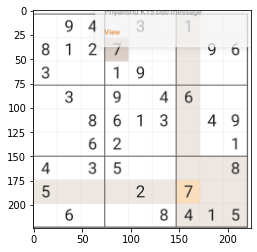

In [35]:
plt.imshow(train_images[31])

In [56]:
from sklearn.preprocessing import LabelBinarizer
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0]])

In [54]:
from keras.utils import np_utils
num_classes = 2
y_test = np_utils.to_categorical(y_new, num_classes)

In [55]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [47]:
import np_utils

In [57]:
lb = LabelBinarizer()

labels = lb.fit_transform(y_new)
print(labels)
labels = np_utils.to_categorical(labels)
print(labels)
# print("which position represents for cat and dog?:")
# print("Data is:",data)
# print(labels)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
